In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

In [2]:
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size*percentage/100)]

def make_dataset(dataset, n_bus):
    x_raw_1, y_raw_1 = [], []
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        for n in range(n_bus):
            x_raw_1.append(list([dataset[i, 4*n+1], dataset[i, 4*n+2]]))
            y_raw_1.extend(dataset[i, 4*n+3:4*n+5])

        x_raw.append(list(x_raw_1))
        y_raw.append(y_raw_1)
        x_raw_1, y_raw_1 = [], []

    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw

def normalize_dataset(x, y):
    x_mean = torch.mean(x,0)
    y_mean = torch.mean(y,0)
    x_std = torch.std(x,0)
    y_std = torch.std(y,0)
    x_norm = (x-x_mean)/x_std
    y_norm = (y-y_mean)/y_std
    x_norm = torch.where(torch.isnan(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isnan(y_norm), torch.zeros_like(y_norm), y_norm)
    x_norm = torch.where(torch.isinf(x_norm), torch.zeros_like(x_norm), x_norm)
    y_norm = torch.where(torch.isinf(y_norm), torch.zeros_like(y_norm), y_norm)
    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    y = y_norm*y_std+y_mean
    return y

def NRMSE(yhat,y):
    return torch.sqrt(torch.mean(((yhat-y)/torch.std(yhat,0))**2))

def MSE(yhat,y):
    return torch.mean((yhat-y)**2)

In [3]:
dataset1 = pd.read_excel('dataset\Grid_14 bus_1.xlsx').values
dataset2 = pd.read_excel('dataset\Grid_14 bus_2.xlsx').values

In [4]:
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1, train_percentage)
val_dataset = slice_dataset(dataset2, val_percentage)

n_bus = 14

#actual data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

#normalized data
x_norm_train, y_norm_train, _, _, _, _ = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

In [5]:
x_train, y_train = x_norm_train, y_norm_train
x_val, y_val = x_norm_val, y_norm_val
edge_index = torch.tensor([[0, 1, 1, 2, 1, 3, 2, 4, 3, 5, 4, 6, 4, 7, 5, 8, 5, 9, 1, 10, 10, 11, 11, 12, 11, 13],
                           [1, 0, 2, 1, 3, 1, 4, 2, 5, 3, 6, 4, 7, 4, 8, 5, 9, 5, 10, 1, 11, 10, 12, 11, 13, 11]], dtype=torch.long)

data_train_list, data_val_list = [], []
for i,_ in enumerate(x_train):
    data_train_list.append(Data(x=x_train[i], y=y_train[i], edge_index=edge_index))
for i,_ in enumerate(x_val):
    data_val_list.append(Data(x=x_val[i], y=y_val[i], edge_index=edge_index))

train_loader = DataLoader(data_train_list, batch_size=1)
val_loader = DataLoader(data_val_list, batch_size=1)

In [6]:
class My_GNN_GNN_NN(torch.nn.Module):
    def __init__(self, node_size=None, feat_in=None, feat_size1=None, feat_size2=None, hidden_size1=None, output_size=None):
        super(My_GNN_GNN_NN, self).__init__()
        self.feat_in = feat_in if feat_in is not None else 2
        self.feat_size1 = feat_in if feat_in is not None else 5
        self.feat_size2 = feat_in if feat_in is not None else 4
        self.hidden_size1 = hidden_size1 if hidden_size1 is not None else 38
        self.output_size = output_size if output_size is not None else 18
        
        self.conv1 = GCNConv(feat_in, feat_size1)
        self.conv2 = GCNConv(feat_size1, feat_size2)
        self.lin1 = Linear(node_size*feat_size2, hidden_size1)
        self.lin2 = Linear(hidden_size1, output_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        
        x = self.conv2(x, edge_index)
        x = torch.tanh(x)

        x = x.flatten(start_dim = 0)
        x = self.lin1(x)
        x = torch.tanh(x)

        x = self.lin2(x)

        return x
    
    def save_weights(self, model, name):
        torch.save(model, name)

In [7]:

feat_in = 2
feat_size1 = 8
feat_size2 = 4
hidden_size1 = 30
output_size = n_bus*2
lr = 0.0001

model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size)
for name, param in model.named_parameters():
  print(name)
  print(param.size())

param = sum(p.numel() for p in model.parameters() if p.requires_grad)
param

conv1.weight
torch.Size([2, 8])
conv1.bias
torch.Size([8])
conv2.weight
torch.Size([8, 4])
conv2.bias
torch.Size([4])
lin1.weight
torch.Size([30, 56])
lin1.bias
torch.Size([30])
lin2.weight
torch.Size([28, 30])
lin2.bias
torch.Size([28])


2638

In [8]:
%%time

feat_in = 2
feat_size1 = 8
feat_size2 = 4
hidden_size1 = 30
output_size = n_bus*2
lr = 0.0001

model = My_GNN_GNN_NN(n_bus, feat_in, feat_size1, feat_size2, hidden_size1, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss_list, val_loss_list = [], []

count=0
patience=2000
lossMin = 1e10

for epoch in range(2001):

    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y_train_prediction = model(batch)
        loss = MSE(denormalize_output(y_train_prediction, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss=0
    for batch in val_loader:
        y_val_prediction = model(batch)
        loss = MSE(denormalize_output(y_val_prediction, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        val_loss += loss.item() * batch.num_graphs
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    #early stopping
    if (val_loss < lossMin):
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
    else:
        count+=1
        if(count>patience):
            print("early stop at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
            print("best val at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(best_epoch, best_train_loss, best_val_loss))
            break
    
    if (train_loss <= 0):
        print("min train loss at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
        break

    if (epoch % 10) == 0:
        print('epoch: {:d}    train loss: {:.7f}    val loss: {:.7f}'.format(epoch, train_loss, val_loss))

epoch: 0    train loss: 0.1537334    val loss: 0.0221647
epoch: 10    train loss: 0.0041269    val loss: 0.0040684
epoch: 20    train loss: 0.0029323    val loss: 0.0030754
epoch: 30    train loss: 0.0023691    val loss: 0.0025800
epoch: 40    train loss: 0.0019231    val loss: 0.0021512
epoch: 50    train loss: 0.0014367    val loss: 0.0016353
epoch: 60    train loss: 0.0011500    val loss: 0.0013308
epoch: 70    train loss: 0.0010074    val loss: 0.0011741
epoch: 80    train loss: 0.0009034    val loss: 0.0010557
epoch: 90    train loss: 0.0008166    val loss: 0.0009562
epoch: 100    train loss: 0.0007411    val loss: 0.0008697
epoch: 110    train loss: 0.0006742    val loss: 0.0007940
epoch: 120    train loss: 0.0006149    val loss: 0.0007281
epoch: 130    train loss: 0.0005620    val loss: 0.0006714
epoch: 140    train loss: 0.0005155    val loss: 0.0006239
epoch: 150    train loss: 0.0004745    val loss: 0.0005849
epoch: 160    train loss: 0.0004381    val loss: 0.0005531
epoch: 1

epoch: 1390    train loss: 0.0000354    val loss: 0.0003095
epoch: 1400    train loss: 0.0000352    val loss: 0.0003100
epoch: 1410    train loss: 0.0000350    val loss: 0.0003105
epoch: 1420    train loss: 0.0000348    val loss: 0.0003109
epoch: 1430    train loss: 0.0000346    val loss: 0.0003115
epoch: 1440    train loss: 0.0000344    val loss: 0.0003120
epoch: 1450    train loss: 0.0000343    val loss: 0.0003125
epoch: 1460    train loss: 0.0000341    val loss: 0.0003131
epoch: 1470    train loss: 0.0000339    val loss: 0.0003137
epoch: 1480    train loss: 0.0000337    val loss: 0.0003143
epoch: 1490    train loss: 0.0000335    val loss: 0.0003149
epoch: 1500    train loss: 0.0000333    val loss: 0.0003155
epoch: 1510    train loss: 0.0000331    val loss: 0.0003161
epoch: 1520    train loss: 0.0000329    val loss: 0.0003167
epoch: 1530    train loss: 0.0000327    val loss: 0.0003173
epoch: 1540    train loss: 0.0000325    val loss: 0.0003179
epoch: 1550    train loss: 0.0000323    

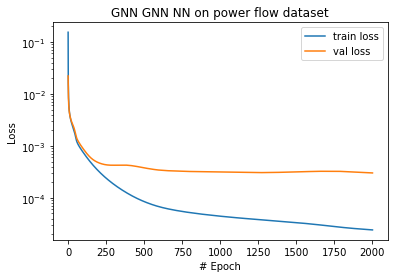

last epoch: 2000, train loss: 0.0000241, val loss: 0.0003012
best epoch: 2000, train loss: 0.0000241, val loss: 0.0003012


In [9]:
plt.title('GNN GNN NN on power flow dataset')
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.yscale('log')
plt.xlabel("# Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

print('last epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(epoch, train_loss, val_loss))
print('best epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(best_epoch, best_train_loss, best_val_loss))

In [10]:
model.eval()

y_train_prediction_1 = model(train_loader.dataset[0])
train_loss_1 = MSE(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_train[0], y_val_mean, y_val_std))
print("[1 datapoint] Train output ground-truth: \n" + str(y_raw_train[0].detach().numpy()))
print("[1 datapoint] Train output prediction: \n" + str(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Train loss (MSE): {:.7f}'.format(train_loss_1))

train_loss = 0
for batch in train_loader:
    pred = model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    train_loss += loss.item() * batch.num_graphs
train_loss /= len(train_loader.dataset)
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("=========================================================================")

y_val_prediction_1 = model(val_loader.dataset[0])
val_loss_1 = MSE(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_val[0], y_val_mean, y_val_std))
print("[1 datapoint] Val output ground-truth: \n" + str(y_raw_val[0].detach().numpy()))
print("[1 datapoint] Val output prediction: \n" + str(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Val loss (MSE): {:.7f}'.format(val_loss_1))

val_loss=0
for batch in val_loader:
    pred = model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    val_loss += loss.item() * batch.num_graphs
val_loss /= len(val_loader.dataset)
print('Val loss (MSE): {:.7f}'.format(val_loss))

[1 datapoint] Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
[1 datapoint] Train output prediction: 
[  10.32485 -154.21043    9.88219 -156.11086    9.75412 -156.70464
    9.72574 -156.8286     9.65994 -157.15352    9.60771 -157.38568
    9.61815 -157.3611     9.62844 -157.30487    9.58253 -157.49971
    9.56058 -157.61708    9.77272 -156.61021    9.68278 -157.03413
    9.65834 -157.14716    9.66356 -157.12132]
[1 datapoint] Train loss (MSE): 0.0000250
Train loss (MSE): 0.0000313
[1 datapoint] Val output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869

In [11]:
best_model = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
best_model.eval()

y_train_prediction_1 = best_model(train_loader.dataset[0])
train_loss_1 = MSE(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_train[0], y_val_mean, y_val_std))
print("[1 datapoint] Train output ground-truth: \n" + str(y_raw_train[0].detach().numpy()))
print("[1 datapoint] Train output prediction: \n" + str(denormalize_output(y_train_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Train loss (MSE): {:.7f}'.format(train_loss_1))

train_loss = 0
for batch in train_loader:
    pred = best_model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    train_loss += loss.item() * batch.num_graphs
train_loss /= len(train_loader.dataset)
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("=========================================================================")

y_val_prediction_1 = best_model(val_loader.dataset[0])
val_loss_1 = MSE(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std), denormalize_output(y_norm_val[0], y_val_mean, y_val_std))
print("[1 datapoint] Val output ground-truth: \n" + str(y_raw_val[0].detach().numpy()))
print("[1 datapoint] Val output prediction: \n" + str(denormalize_output(y_val_prediction_1, y_val_mean, y_val_std).detach().numpy()))
print('[1 datapoint] Val loss (MSE): {:.7f}'.format(val_loss_1))

val_loss=0
for batch in val_loader:
    pred = best_model(batch)
    loss = MSE(denormalize_output(pred, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
    val_loss += loss.item() * batch.num_graphs
val_loss /= len(val_loader.dataset)
print('Val loss (MSE): {:.7f}'.format(val_loss))

[1 datapoint] Train output ground-truth: 
[  10.324 -154.216    9.882 -156.117    9.753 -156.712    9.724 -156.839
    9.659 -157.161    9.607 -157.399    9.617 -157.37     9.627 -157.311
    9.581 -157.512    9.56  -157.633    9.773 -156.613    9.682 -157.039
    9.658 -157.152    9.664 -157.123]
[1 datapoint] Train output prediction: 
[  10.32485 -154.21043    9.88219 -156.11086    9.75412 -156.70464
    9.72574 -156.8286     9.65994 -157.15352    9.60771 -157.38568
    9.61815 -157.3611     9.62844 -157.30487    9.58253 -157.49971
    9.56058 -157.61708    9.77272 -156.61021    9.68278 -157.03413
    9.65834 -157.14716    9.66356 -157.12132]
[1 datapoint] Train loss (MSE): 0.0000250
Train loss (MSE): 0.0000313
[1 datapoint] Val output ground-truth: 
[  10.302 -154.788    9.844 -156.745    9.686 -157.465    9.685 -157.484
    9.574 -157.989    9.568 -158.053    9.543 -158.141    9.532 -158.187
    9.518 -158.294    9.535 -158.209    9.727 -157.275    9.629 -157.731
    9.599 -157.869

In [12]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    x_test, y_test = x_norm_test, y_norm_test
    
    data_test_list = []
    for j,_ in enumerate(x_test):
        data_test_list.append(Data(x=x_test[j], y=y_test[j], edge_index=edge_index))

    test_loader = DataLoader(data_test_list, batch_size=1)
    
    print('dataset {:d}'.format(i+1))
    
    test_loss = 0
    for batch in test_loader:
        y_test_prediction = best_model(batch)
        loss = MSE(denormalize_output(y_test_prediction, y_val_mean, y_val_std), denormalize_output(batch.y, y_val_mean, y_val_std))
        test_loss += loss.item() * batch.num_graphs
    test_loss /= len(test_loader.dataset)
    
    if i == 0:
        print('Train loss (MSE): {:.7f}'.format(test_loss))
    elif i == 1:
        print('Val loss (MSE): {:.7f}'.format(test_loss))
    else:
        print('Test loss (MSE): {:.7f}'.format(test_loss))
        test_loss_list.append(test_loss)
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [MSE] GNN GNN NN test loss.xlsx")
print("\ntest loss file saved!\n")

dataset 1
Train loss (MSE): 0.0000313
dataset 2
Val loss (MSE): 0.0003012
dataset 3
Test loss (MSE): 0.0001376
dataset 4
Test loss (MSE): 0.0002257
dataset 5
Test loss (MSE): 0.0000845
dataset 6
Test loss (MSE): 0.0000494
dataset 7
Test loss (MSE): 0.0001754
dataset 8
Test loss (MSE): 0.0000878
dataset 9
Test loss (MSE): 0.0000876
dataset 10
Test loss (MSE): 0.0000969
dataset 11
Test loss (MSE): 0.0001296
dataset 12
Test loss (MSE): 0.0001576
dataset 13
Test loss (MSE): 0.0000549
dataset 14
Test loss (MSE): 0.0001378
dataset 15
Test loss (MSE): 0.0001066
dataset 16
Test loss (MSE): 0.0000850
dataset 17
Test loss (MSE): 0.0000806
dataset 18
Test loss (MSE): 0.0001702
dataset 19
Test loss (MSE): 0.0001532
dataset 20
Test loss (MSE): 0.0001554
dataset 21
Test loss (MSE): 0.0000886
dataset 22
Test loss (MSE): 0.0000702
dataset 23
Test loss (MSE): 0.0001485
dataset 24
Test loss (MSE): 0.0001794
dataset 25
Test loss (MSE): 0.0001070
dataset 26
Test loss (MSE): 0.0001093
dataset 27
Test loss 

In [13]:
%%time

best_model = torch.load("[PyG] [14 bus] Best_GNN_GNN_NN_model.pt")
best_model.eval()

test_loss_list = []

for i in range(102):
    
    dataset = pd.read_excel('dataset\Grid_14 bus_%d.xlsx' % (i+1)).values
    test_percentage = 100
    test_dataset = slice_dataset(dataset, test_percentage)
    x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)
    x_norm_test, y_norm_test, _, _, _, _ = normalize_dataset(x_raw_test, y_raw_test)
    
    x_test, y_test = x_norm_test, y_norm_test
    
    data_test_list = []
    for j,_ in enumerate(x_test):
        data_test_list.append(Data(x=x_test[j], y=y_test[j], edge_index=edge_index))

    test_loader = DataLoader(data_test_list, batch_size=1)
    
    print('dataset {:d}'.format(i+1))
    
    test_loss = 0
    yhat = torch.empty(0, n_bus*2)
    for batch in test_loader:
        y_test_prediction = best_model(batch)
        yhat = torch.cat((yhat, y_test_prediction.reshape(1, n_bus*2)))
    
    yhat = denormalize_output(yhat, y_val_mean, y_val_std)
    y = y_raw_test
    test_loss_NRMSE = NRMSE(yhat, y)
    
    if i == 0:
        print('Train loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    elif i == 1:
        print('Val loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
    else:
        print('Test loss (NRMSE): {:.7f}'.format(test_loss_NRMSE.detach().numpy()))
        test_loss_list.append(test_loss_NRMSE.detach().numpy())
    
    print("===========================")

column = []
for i in range(100):
    column.append('test loss %d' % (i+1))
    
test_loss_file = pd.DataFrame([test_loss_list], columns=column)
test_loss_file.to_excel("[PyG] [14 bus] [NRMSE] GNN GNN NN test loss.xlsx")
print("\ntest loss file saved!\n")

dataset 1
Train loss (NRMSE): 0.0320580
dataset 2
Val loss (NRMSE): 0.0303914
dataset 3
Test loss (NRMSE): 0.0314084
dataset 4
Test loss (NRMSE): 0.0348826
dataset 5
Test loss (NRMSE): 0.0371720
dataset 6
Test loss (NRMSE): 0.0290156
dataset 7
Test loss (NRMSE): 0.0509769
dataset 8
Test loss (NRMSE): 0.0682174
dataset 9
Test loss (NRMSE): 0.0327468
dataset 10
Test loss (NRMSE): 0.0561564
dataset 11
Test loss (NRMSE): 0.0462868
dataset 12
Test loss (NRMSE): 0.0393915
dataset 13
Test loss (NRMSE): 0.0307153
dataset 14
Test loss (NRMSE): 0.0315468
dataset 15
Test loss (NRMSE): 0.0319377
dataset 16
Test loss (NRMSE): 0.0335499
dataset 17
Test loss (NRMSE): 0.0359092
dataset 18
Test loss (NRMSE): 0.0411022
dataset 19
Test loss (NRMSE): 0.0307250
dataset 20
Test loss (NRMSE): 0.0383114
dataset 21
Test loss (NRMSE): 0.0445544
dataset 22
Test loss (NRMSE): 0.0373744
dataset 23
Test loss (NRMSE): 0.0351655
dataset 24
Test loss (NRMSE): 0.0569242
dataset 25
Test loss (NRMSE): 0.0478730
dataset 2